# Method 2 Improved: CNN with Enhanced Preprocessing
**Goal:** Train a robust Convolutional Neural Network (CNN) for music genre classification.

**Key Improvements:**
- **Multi-resolution features**: Stacked Mel spectrograms with temporal derivatives (Delta and Delta-Delta) to capture dynamic spectral changes.
- **SpecAugment**: Use time and frequency masking during training to improve generalization.
- **GroupShuffleSplit**: Ensures rigorous evaluation by preventing song-level data leakage.

### Imports
**Description:** Import libraries for audio processing (librosa), deep learning (TensorFlow/Keras), and standard data science tools.

**Outputs:**
- Loaded libraries
- Prints TensorFlow version

In [15]:
import numpy as np
import librosa
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, BatchNormalization, MaxPooling2D,
                                     GlobalAveragePooling2D, Dense, Dropout, LeakyReLU)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

print(f'TensorFlow: {tf.__version__}')

TensorFlow: 2.15.0


## 1. Configuration
**Description:** Set up global parameters. Note the `TARGET_LENGTH` which defines the time dimension input size for the CNN.
**Outputs:**
- Configuration constants

In [16]:
DATA_PATH = '../data/gtzan/genres_original'
SAMPLE_RATE = 22050
DURATION = 30
N_MELS = 128
N_FFT = 2048
HOP_LENGTH = 512
TARGET_LENGTH = 1291  # ~30 seconds at hop_length=512

GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop',
          'jazz', 'metal', 'pop', 'reggae', 'rock']
NUM_CLASSES = len(GENRES)

## 2. Enhanced Feature Extraction with Multi-Resolution
**Description:** 
- `extract_melspec`: Standard Mel spectrogram extraction.
- `extract_multi_resolution`: Computes first (Delta) and second (Delta-Delta) derivatives of the spectrogram. Stacks them into a 3-channel tensor (similar to RGB images), allowing the CNN to learn from static, velocity, and acceleration spectral features.

**Inputs:**
- Raw audio

**Outputs:**
- 3D Feature Tensor: `(time_steps, n_mels, 3)`

In [17]:
def extract_melspec(audio, sr, n_mels=128, target_length=TARGET_LENGTH):
    """Extract mel spectrogram with padding/truncation."""
    mel = librosa.feature.melspectrogram(
        y=audio, sr=sr, n_mels=n_mels, n_fft=N_FFT, hop_length=HOP_LENGTH
    )
    mel_db = librosa.power_to_db(mel, ref=np.max)
    
    # Transpose to (time, frequency)
    mel_db = mel_db.T
    
    # Pad or truncate
    if mel_db.shape[0] < target_length:
        pad_width = target_length - mel_db.shape[0]
        mel_db = np.pad(mel_db, ((0, pad_width), (0, 0)), mode='constant')
    else:
        mel_db = mel_db[:target_length, :]
    
    return mel_db

def extract_multi_resolution(audio, sr):
    """
    Extract multi-resolution features:
    - Mel spectrogram (128 mels)
    - Delta (first derivative)
    - Delta-delta (second derivative)
    Returns: (time, freq, 3) tensor
    """
    mel = extract_melspec(audio, sr, n_mels=128)
    
    # Compute deltas along time axis
    delta = librosa.feature.delta(mel.T).T
    delta2 = librosa.feature.delta(mel.T, order=2).T
    
    # Stack as channels
    return np.stack([mel, delta, delta2], axis=-1)

# Test
test_audio = np.random.randn(SAMPLE_RATE * 30)
test_features = extract_multi_resolution(test_audio, SAMPLE_RATE)
print(f"Feature shape: {test_features.shape}")

Feature shape: (1291, 128, 3)


## 3. SpecAugment Data Augmentation
**Description:** Implement SpecAugment, a data augmentation technique for spectrograms. It randomly masks localized blocks of time steps and frequency headers, forcing the model to be robust to partial signal loss.

**Inputs:**
- Mel spectrogram

**Outputs:**
- Augmented Mel spectrogram with masked regions

In [18]:
def spec_augment(mel, time_mask_param=80, freq_mask_param=20, num_masks=2):
    """
    Apply SpecAugment: time and frequency masking.
    """
    augmented = mel.copy()
    time_steps, freq_bins = augmented.shape[:2]
    
    # Time masking
    for _ in range(num_masks):
        t = np.random.randint(0, time_mask_param)
        t0 = np.random.randint(0, max(1, time_steps - t))
        augmented[t0:t0+t, :] = 0
    
    # Frequency masking
    for _ in range(num_masks):
        f = np.random.randint(0, freq_mask_param)
        f0 = np.random.randint(0, max(1, freq_bins - f))
        augmented[:, f0:f0+f] = 0
    
    return augmented

## 4. Load Dataset
**Description:** Load GTZAN dataset audio files and extract features. If `augment=True`, it generates an additional augmented version of each song using SpecAugment, effectively doubling the training data.

**Inputs:**
- `DATA_PATH`
- `augment`: Boolean flag

**Outputs:**
- `X`, `y`, `song_ids`

In [19]:
def load_dataset(data_path, augment=False):
    X, y, song_ids = [], [], []
    
    for genre in GENRES:
        genre_path = os.path.join(data_path, genre)
        if not os.path.exists(genre_path):
            continue
            
        files = sorted([f for f in os.listdir(genre_path) if f.endswith('.wav')])
        
        for filename in tqdm(files, desc=f"{genre}"):
            if 'jazz.00054' in filename:
                continue
                
            filepath = os.path.join(genre_path, filename)
            song_id = f"{genre}.{filename.split('.')[1]}"
            
            try:
                audio, sr = librosa.load(filepath, sr=SAMPLE_RATE, duration=DURATION)
                target_len = SAMPLE_RATE * DURATION
                if len(audio) < target_len:
                    audio = np.pad(audio, (0, target_len - len(audio)))
                
                # Extract features
                features = extract_multi_resolution(audio, sr)
                X.append(features)
                y.append(genre)
                song_ids.append(song_id)
                
                # Augmentation
                if augment:
                    aug_features = spec_augment(features)
                    X.append(aug_features)
                    y.append(genre)
                    song_ids.append(song_id)
                    
            except Exception as e:
                print(f"Error: {filename}: {e}")
    
    return np.array(X), np.array(y), np.array(song_ids)

print("Loading dataset...")
X, y, song_ids = load_dataset(DATA_PATH, augment=True)
print(f"\nDataset: {X.shape}")
print(f"Unique songs: {len(np.unique(song_ids))}")

Loading dataset...


rock: 100%|██████████| 100/100 [00:02<00:00, 44.23it/s]



Dataset: (1998, 1291, 128, 3)
Unique songs: 999


## 5. GroupShuffleSplit by Song ID
**Description:** Split dataset ensuring no song overlap between sets using `GroupShuffleSplit` on `song_ids`. The split is approximately 70% Train, 10% Val, 20% Test.

**Inputs:**
- Features `X`, Labels `y`, Groups `song_ids`

**Outputs:**
- `X_train`, `X_val`, `X_test` and corresponding labels


In [20]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_cat = to_categorical(y_encoded, NUM_CLASSES)

# Split by song
splitter = GroupShuffleSplit(test_size=0.20, n_splits=1, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, song_ids))

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y_cat[train_idx], y_cat[test_idx]

# Further split train into train/val
songs_train = song_ids[train_idx]
splitter_val = GroupShuffleSplit(test_size=0.125, n_splits=1, random_state=42)
train_idx2, val_idx = next(splitter_val.split(X_train, y_train, songs_train))

X_val = X_train[val_idx]
y_val = y_train[val_idx]
X_train = X_train[train_idx2]
y_train = y_train[train_idx2]

print(f"Train: {X_train.shape}")
print(f"Val: {X_val.shape}")
print(f"Test: {X_test.shape}")

Train: (1398, 1291, 128, 3)
Val: (200, 1291, 128, 3)
Test: (400, 1291, 128, 3)


## 6. Normalization
**Description:** Normalize features using per-channel statistics (mean and std calculated over the training set). This treats the data appropriately as a multi-channel image input for the CNN.

**Inputs:**
- `X_train` statistics

**Outputs:**
- Normalized datasets
- Variables `mean` and `std` for later saving.


In [21]:
# Normalize per-channel
mean = X_train.mean(axis=(0, 1, 2), keepdims=True)
std = X_train.std(axis=(0, 1, 2), keepdims=True) + 1e-8

X_train = (X_train - mean) / std
X_val = (X_val - mean) / std
X_test = (X_test - mean) / std

print(f"Normalized shape: {X_train.shape}")

Normalized shape: (1398, 1291, 128, 3)


## 7. Build CNN Model
**Description:** Construct a 2D Convolutional Neural Network. 
- **4 Conv Blocks**: Each with Conv2D, LeakyReLU, BatchNormalization, and MaxPooling2D.
- **GlobalAveragePooling2D**: Reduces spatial dimensions before the dense classifier.
- **Dense Classifier**: Dropout regularization and Softmax output.

**Inputs:**
- `input_shape`: (1291, 128, 3)
- `num_classes`: 10

**Outputs:**
- Compiled Keras `model`

In [22]:
def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        # Block 1
        Conv2D(64, (3, 3), padding='same', input_shape=input_shape),
        LeakyReLU(0.1),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Block 2
        Conv2D(128, (3, 3), padding='same'),
        LeakyReLU(0.1),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Block 3
        Conv2D(256, (3, 3), padding='same'),
        LeakyReLU(0.1),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Block 4
        Conv2D(512, (3, 3), padding='same'),
        LeakyReLU(0.1),
        BatchNormalization(),
        GlobalAveragePooling2D(),
        
        # Classifier
        Dense(256),
        LeakyReLU(0.1),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_cnn_model(X_train.shape[1:], NUM_CLASSES)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 1291, 128, 64)     1792      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 1291, 128, 64)     0         
                                                                 
 batch_normalization_4 (Bat  (None, 1291, 128, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 645, 64, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 645, 64, 128)      73856     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 645, 64, 128)     

## 8. Training
**Description:** Train the CNN with callbacks for Early Stopping (patience=15) and Learning Rate Reduction on plateau.

**Outputs:**
- Trained `model`
- `history` logs

In [23]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100


2025-12-07 20:08:25.379297: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


88/88 [==============================] - 28s 297ms/step - loss: 1.8607 - accuracy: 0.3727 - val_loss: 3.8098 - val_accuracy: 0.1550 - lr: 0.0010
Epoch 2/100
88/88 [==============================] - 26s 293ms/step - loss: 1.3343 - accuracy: 0.5236 - val_loss: 4.0188 - val_accuracy: 0.2800 - lr: 0.0010
Epoch 3/100
88/88 [==============================] - 27s 303ms/step - loss: 1.1625 - accuracy: 0.5823 - val_loss: 4.7933 - val_accuracy: 0.1850 - lr: 0.0010
Epoch 4/100
88/88 [==============================] - 26s 294ms/step - loss: 1.0290 - accuracy: 0.6309 - val_loss: 2.9179 - val_accuracy: 0.4200 - lr: 0.0010
Epoch 5/100
88/88 [==============================] - 26s 295ms/step - loss: 0.8559 - accuracy: 0.7089 - val_loss: 2.5763 - val_accuracy: 0.3650 - lr: 0.0010
Epoch 6/100
88/88 [==============================] - 26s 297ms/step - loss: 0.7574 - accuracy: 0.7396 - val_loss: 2.8539 - val_accuracy: 0.3150 - lr: 0.0010
Epoch 7/100
88/88 [==============================] - 26s 294ms/step - 

## 9. Evaluation
**Description:** Evaluate performance on the Test set. Generates accuracy/loss plots and classification metrics.

**Outputs:**
- Test Accuracy
- Classification Report


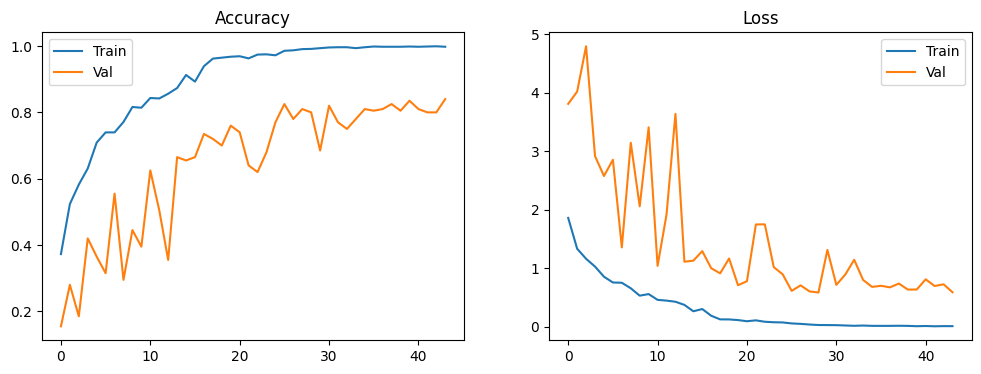


Test Accuracy: 84.25%
13/13 [==============================] - 3s 231ms/step

Classification Report:
              precision    recall  f1-score   support

       blues       0.75      1.00      0.86        42
   classical       0.92      1.00      0.96        24
     country       0.80      0.81      0.80        48
       disco       0.87      0.77      0.82        44
      hiphop       0.84      0.90      0.87        30
        jazz       0.98      0.96      0.97        54
       metal       0.92      0.94      0.93        36
         pop       0.73      0.79      0.76        38
      reggae       0.79      0.86      0.83        44
        rock       0.89      0.42      0.58        40

    accuracy                           0.84       400
   macro avg       0.85      0.85      0.84       400
weighted avg       0.85      0.84      0.84       400



In [24]:
# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(history.history['accuracy'], label='Train')
axes[0].plot(history.history['val_accuracy'], label='Val')
axes[0].set_title('Accuracy')
axes[0].legend()

axes[1].plot(history.history['loss'], label='Train')
axes[1].plot(history.history['val_loss'], label='Val')
axes[1].set_title('Loss')
axes[1].legend()
plt.show()

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))

## 10. Save Model
**Description:** Save the final trained model and the normalization parameters. Note that for multi-resolution data, `mean` and `std` are saved as arrays suitable for broadcasting.

**Outputs:**
- `../models/cnn_enhanced.keras`
- `../models/norm_params.npz` (also saves individual npy files)

In [25]:
model.save('../models/cnn_enhanced.keras')
np.savez('../models/norm_params.npz', mean=mean, std=std)
# Option 2: Save as individual .npy files
np.save('../models/mean.npy', mean)
np.save('../models/std.npy', std)
# To load later:
params = np.load('../models/norm_params.npz')
mean = params['mean']
std = params['std']
print("Model saved!")

Model saved!
